# Tutorial: Splitting a large imaging file into inidividual colonies
---

This file imports illustrates how to segment a large microscopy images with multiple colonies into seperate files, each containing one colony.

First, you need a copy of `find_colonies.py`, the file that contains the actual code. Then you need to link it by specifying the path to the folder in which `find_colonies.py` is located on the next line.

In [2]:
path_to_find_colonies = '/Users/jakob/Documents/RU/Code/segment/'

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
from importlib import reload
import sys
sys.path.append(path_to_find_colonies) #link to find_colonies.py -->
import find_colonies
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
import time
import pylab as pl
from IPython import display
from ipywidgets import FloatProgress
from glob import glob
import re
import os
import imageio
import czifile
from tqdm import tqdm_notebook, tqdm
from os.path import join
from pprint import pprint
import tifffile as tiff

Specify a directory in which image files are located, and find file names with specific ending, e.g. `.czi`

In [4]:
datadir = 'data/'
files_to_max = sorted(glob(datadir+'/*.czi'))
pprint(files_to_max)

['data/20CAG-treated-NCAD-PAX6-SOX10-COL4-DAPI-grid-1.czi']


If files are z-stacks, use the code below to make a projection from 3d data (e.g. maximum intensity). If files are already 2d, skip this step.

In [5]:
# write the max intensity file
for f in files_to_max:
    file_to_write = os.path.splitext(f)[0]+'_MAX.tif'
    a = czifile.imread(f).squeeze().max(axis=1)
    tiff.imwrite(file_to_write, a)

In [90]:
files = glob('data/*_MAX.tif')
pprint(files)

['data/20CAG-treated-NCAD-PAX6-SOX10-COL4-DAPI-grid-1_MAX.tif']


Get the colony outlines, this is the main computational step and may take a moment for large files. The `get_colony_outlines` takes a number of parameters that can help in segmenting the colonies. First, you should specify which channel number you want to use for segmentation using the `channel_for_segmentation` argument (usually DAPI or anything that has uniform high intensity where the cell are - note that ). Additional optional arguments are

- `lower_threshold` (default = 0.5): Intensity threshold between 0..1 that indicates what intensity should be considered background
- `min_area` (default 22000): Minimum size in pixels that the colony should have. Can help exclude debris and partially attached colonies. If too large, no colonies will be found.
- `min_aspect_ratio` (default 0.7): Minimum aspect ratio for the colonies. If the detected aspect ratio is smaller than this, reject the colony. This helps in selecting only circular colonies and will get rid of joined or otherwise misformed colonies. 

processing file data/20CAG-treated-NCAD-PAX6-SOX10-COL4-DAPI-grid-1_MAX.tif
saved to data/20CAG-treated-NCAD-PAX6-SOX10-COL4-DAPI-grid-1_MAX/colony_bounds.npy


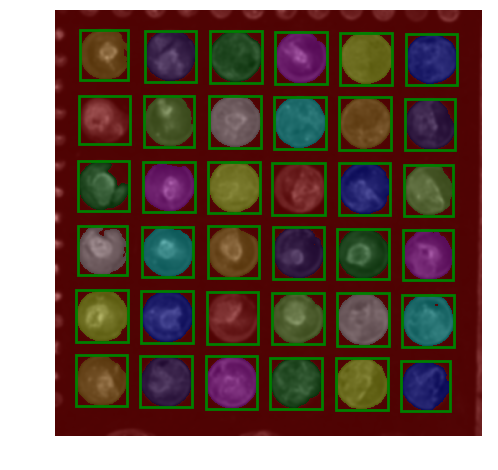

In [92]:
find_colonies.get_colony_outlines(files, channel_for_segmentation=4)

Now apply the segmentation to the images and save individual files for each colony and channel. Specify the file list you want to operate on (usually the same `files` list as above). Additional optional arguments are:

- `show_colonies`: If `True`, display the colonies. This is good for testing that everything works as expected, but is slow. Switch to `False` for very fast segmentation.
- `save_colonies`: If `True`, will save individual colony files. Set to `False` if you want to do a test run with `show_colonies` enabled.
- `desired_shape`: Shape of the squared output files in pixels.
- `downsample_to_8_bit`: If `True`, will downsample images to 8-bit which is standard for machine learning applications.
- `image_bits`: Bit depth of original images, needed for downsampling to 8-bit format. Usually images are in 16-bit format, however, sometimes they are *saved* as 16-bit but are in fact 12-bit. When converting to 8-bit as 16-bit, this will lose dynamic range. The only way to determine this is to check the maximum pixel intensity value: If this is **4095** (i.e. 2^12-1), you actually have a 12-bit image disguised as a 16-bit image. You can test this as shown on the next line

In [100]:
tiff.imread(files[0]).max(), tiff.imread(files[0]).dtype

(4095, dtype('uint16'))

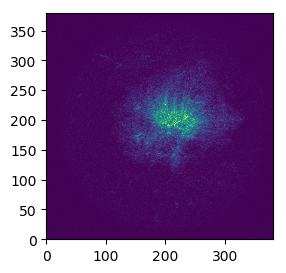

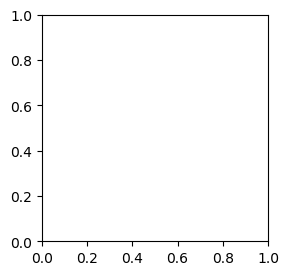

In [107]:
find_colonies.crop_colonies(files, show_colonies=True, save_colonies=True, desired_shape=380, downsample_to_8_bit=True, image_bits=12)